# Robotic Vision System 

## Project Overview

This project aims to develop a **robotic vision system** that can detect objects and predict grasp poses in cluttered environments. The system combines **object detection** with **grasp pose estimation**, using both RGB and depth images to enable accurate robotic interaction with objects. The objective is to build a robust pipeline that can identify objects and determine suitable grasp points, ensuring precise handling of objects in real-world scenarios.

<center>

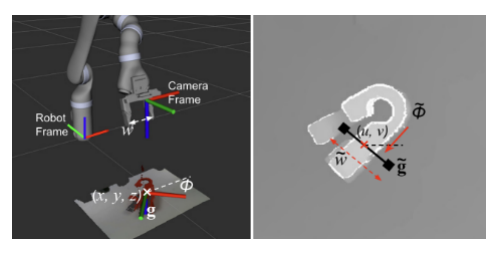

</center>

### Key Deliverables:

1. **Quantitative Results:**
   - The system will output grasp coordinates for objects of interest in JSON format. For each scene, the system should provide:
     - `(u, v)`: Centroid coordinates of the gripper in the image’s original pixel space.
     - `width`: The width of the gripper opening, measured in pixels.
     - `angle`: The rotation angle of the gripper in radians.
     - If an object is not detected in the scene, the result should return `'object not present'`.

   **Example JSON structure:**
   ```json
   {
       "test_1": [u, v, width, angle],
       "test_2": "object not present"
   }
   ```

2. **Grasp Estimation:**
   - The grasp detection system should accurately predict and return the gripper coordinates to enable precise handling of objects, even in dynamic environments.



### Sections Overview
1. **Dataset Preparation and Preprocessing**  
   This section focuses on loading and preparing the dataset, which consists of both RGB and depth images. The images are accompanied by annotations, including bounding boxes and grasp poses, that describe the objects and potential grasp points. The preprocessing steps will ensure the data is properly formatted and aligned for the object detection and grasp pose estimation tasks.

2. **Object Detection**  
   In this part, we will use a pre-trained object detection model (e.g., Mask R-CNN or Faster R-CNN) to detect and localize the target objects in the scene. The model will provide bounding boxes around the objects of interest, which will be essential for isolating the regions of the image where grasp detection will occur.

3. **Grasp Pose Detection**  
   Once the object is detected, this section involves predicting the optimal grasp pose using the depth information. A dedicated grasp detection model will be designed and trained to output the gripper's position, width, and angle based on the depth data, ensuring an effective grasp for each object.

4. **Evaluation and Visualization**  
   This phase is dedicated to evaluating the system's performance. Both object detection and grasp detection results will be analyzed and visualized. The evaluation will include quantitative measures of the model’s accuracy, and visual representations will show detected objects with overlaid predicted grasp poses on both RGB and depth images.

5. **Conclusion and Future Work**  
   The final section provides a summary of the system's overall performance, outlining the key findings from the evaluations. Additionally, potential areas for future enhancement, such as improving the grasp detection accuracy or extending the system for real-time applications, will be discussed.

---


**Import necessary libraries**

In [ ]:
# !mkdir /content/drive/MyDrive/robotic-vision-system/data
# !unrar x '/content/drive/MyDrive/robotic-vision-system/Project_cv1.rar' /content/drive/MyDrive/robotic-vision-system/data

In [ ]:
# %cd /content/drive/MyDrive/robotic-vision-system/data/Project_cv1

In [108]:
from torchvision.io.image import read_image
from torchvision.models.detection import (
                                            fasterrcnn_resnet50_fpn_v2, 
                                            FasterRCNN_ResNet50_FPN_V2_Weights, 
                                            fcos_resnet50_fpn,
                                            FCOS_ResNet50_FPN_Weights,
                                            retinanet_resnet50_fpn_v2,
                                            RetinaNet_ResNet50_FPN_V2_Weights
                                        )

from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torchvision

import torch
from PIL import Image
from colormap import sample_colors
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import math 
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.patches as patches
import cv2



## 1. Dataset Preparation and Preprocessing

In [137]:
#read in validation information
with open('validation_prompts.json','r') as f:
    val_prompts = json.load(f)

#read in gt grasp labels
with open('validation_grasp_labels.json', 'r') as f:
    gt_grasps = json.load(f)

#read in gt object labels
with open('validation_object_labels.json', 'r') as f:
    gt_objects = json.load(f)


#read in test information
with open('test_prompts.json','r') as f:
    test_prompts = json.load(f)

We load the validation and test data, which includes:
- `val_prompts`: Image paths and object labels for validation.
- `gt_grasps`: Ground truth grasp points for each scene.
- `gt_objects`: Object bounding boxes in the validation scenes.
- `test_prompts`: Image paths and object labels for test scenes.

In [89]:
(len(val_prompts),len(gt_grasps),len(gt_objects)) , len(test_prompts)

((620, 620, 620), 341)

In [90]:
val_prompts

{'test_1': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0003.png',
  'banana'],
 'test_2': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0003.png',
  'knife'],
 'test_3': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0008.png',
  'scissors'],
 'test_4': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0011.png',
  'computer mouse'],
 'test_5': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0012.png',
  'computer mouse'],
 'test_6': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0018.png',
  'banana'],
 'test_7': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0018.png',
  'knife'],
 'test_8': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0020.png',
  'bowl'],
 'test_9': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0021.png',
  'banana'],
 'test_10': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0021.png',
  'knife'],
 'test_11': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0024.png',
  'banana'],
 'test_12': ['Graspnet_subset/validatio

We convert the `val_prompts` dictionary into a DataFrame for easier handling of the data. This DataFrame contains the image filenames and object labels for each validation scene.

In [91]:
val_prompts_df = pd.DataFrame(val_prompts).T
val_prompts_df.rename(columns={0:"filename",1:"object"},inplace=True)
val_prompts_df.head()

,filename,object
test_1,Graspnet_subset/validation_scenes/scene_0050/r...,banana
test_2,Graspnet_subset/validation_scenes/scene_0050/r...,knife
test_3,Graspnet_subset/validation_scenes/scene_0050/r...,scissors
test_4,Graspnet_subset/validation_scenes/scene_0050/r...,computer mouse
test_5,Graspnet_subset/validation_scenes/scene_0050/r...,computer mouse


In [92]:
gt_objects

{'test_1': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0003.png',
  'banana',
  [376, 127, 501, 395]],
 'test_2': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0003.png',
  'knife',
  [369, 326, 648, 454]],
 'test_3': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0008.png',
  'scissors',
  []],
 'test_4': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0011.png',
  'computer mouse',
  []],
 'test_5': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0012.png',
  'computer mouse',
  []],
 'test_6': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0018.png',
  'banana',
  [360, 96, 558, 338]],
 'test_7': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0018.png',
  'knife',
  [368, 275, 639, 472]],
 'test_8': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0020.png',
  'bowl',
  []],
 'test_9': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0021.png',
  'banana',
  [364, 90, 554, 341]],
 'test_10': ['Graspnet_subset/validation_scenes/scene_0050/rgb/0021.pn

In [93]:
gt_objects_df = pd.DataFrame(gt_objects).T
gt_objects_df.head()

,0,1,2
test_1,Graspnet_subset/validation_scenes/scene_0050/r...,banana,"[376, 127, 501, 395]"
test_2,Graspnet_subset/validation_scenes/scene_0050/r...,knife,"[369, 326, 648, 454]"
test_3,Graspnet_subset/validation_scenes/scene_0050/r...,scissors,[]
test_4,Graspnet_subset/validation_scenes/scene_0050/r...,computer mouse,[]
test_5,Graspnet_subset/validation_scenes/scene_0050/r...,computer mouse,[]


We integrate object bounding box information into the validation DataFrame. This ensures each scene contains both the image path, object label, and the associated bounding box.

In [94]:
val_prompts_df['bbox'] = gt_objects_df[2].values
val_prompts_df

,filename,object,bbox
test_1,Graspnet_subset/validation_scenes/scene_0050/r...,banana,"[376, 127, 501, 395]"
test_2,Graspnet_subset/validation_scenes/scene_0050/r...,knife,"[369, 326, 648, 454]"
test_3,Graspnet_subset/validation_scenes/scene_0050/r...,scissors,[]
test_4,Graspnet_subset/validation_scenes/scene_0050/r...,computer mouse,[]
test_5,Graspnet_subset/validation_scenes/scene_0050/r...,computer mouse,[]
...,...,...,...
test_616,Graspnet_subset/validation_scenes/scene_0049/r...,bowl,"[346, 0, 695, 341]"
test_617,Graspnet_subset/validation_scenes/scene_0049/r...,bowl,"[392, 0, 720, 338]"
test_618,Graspnet_subset/validation_scenes/scene_0049/r...,knife,[]
test_619,Graspnet_subset/validation_scenes/scene_0049/r...,banana,[]


In [95]:
gt_grasps['test_1'][:3] 

[[[393.3008728027344, 153.67750549316406],
  [457.5617370605469, 130.18824768066406],
  [468.8244323730469, 161.0001678466797],
  [404.5635681152344, 184.4894256591797]],
 [[388.8248596191406, 144.7439422607422],
  [470.3065490722656, 137.27452087402344],
  [473.3004455566406, 169.93373107910156],
  [391.8187561035156, 177.4031524658203]],
 [[385.5792541503906, 132.98062133789062],
  [482.0324401855469, 149.33004760742188],
  [476.5460510253906, 181.69705200195312],
  [380.0928649902344, 165.34762573242188]]]

In [96]:
len(gt_grasps['test_1']),len(gt_grasps['test_1'][0]),len(gt_grasps['test_1'][0][0])

(2042, 4, 2)

We remove scenes that lack valid bounding boxes or grasp points. This ensures we only keep scenes that contain both necessary object and grasp information for further processing

In [97]:
# Create a list of indices where either 'box' in val_prompts_df is empty or the corresponding gt_grasps is empty
indices_to_remove = [index for index in val_prompts_df.index if len(val_prompts_df.loc[index, 'bbox'])==0  
                     or  len(gt_grasps[index])==0]

# Drop the rows in val_prompts_df where 'box' is empty or gt_grasps is empty
val_prompts_df = val_prompts_df.drop(indices_to_remove)

# Remove the corresponding entries from gt_grasps
gt_grasps = {key: value for key, value in gt_grasps.items() if key not in indices_to_remove}

# Display the cleaned dataframe and grasp dictionary

print(f" gt_grasps number : {len(gt_grasps)}")

display(val_prompts_df)


 gt_grasps number : 500


,filename,object,bbox
test_1,Graspnet_subset/validation_scenes/scene_0050/r...,banana,"[376, 127, 501, 395]"
test_6,Graspnet_subset/validation_scenes/scene_0050/r...,banana,"[360, 96, 558, 338]"
test_7,Graspnet_subset/validation_scenes/scene_0050/r...,knife,"[368, 275, 639, 472]"
test_9,Graspnet_subset/validation_scenes/scene_0050/r...,banana,"[364, 90, 554, 341]"
test_10,Graspnet_subset/validation_scenes/scene_0050/r...,knife,"[373, 273, 639, 474]"
...,...,...,...
test_613,Graspnet_subset/validation_scenes/scene_0049/r...,bowl,"[206, 1, 610, 369]"
test_614,Graspnet_subset/validation_scenes/scene_0049/r...,bowl,"[121, 78, 591, 391]"
test_616,Graspnet_subset/validation_scenes/scene_0049/r...,bowl,"[346, 0, 695, 341]"
test_617,Graspnet_subset/validation_scenes/scene_0049/r...,bowl,"[392, 0, 720, 338]"


In [98]:
val_prompts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, test_1 to test_620
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  500 non-null    object
 1   object    500 non-null    object
 2   bbox      500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


We convert the `test_prompts` dictionary into a DataFrame for easy access to the test scene information. This will be used during evaluation for predicting grasp points.

In [99]:
test_prompts_df = pd.DataFrame(test_prompts).T
test_prompts_df.rename(columns={0:"filename",1:"object"},inplace=True)
display(test_prompts_df.head(),test_prompts_df.shape)

,filename,object
test_1,Graspnet_subset/test_scenes/scene_0030/rgb/000...,scissors
test_2,Graspnet_subset/test_scenes/scene_0030/rgb/000...,banana
test_3,Graspnet_subset/test_scenes/scene_0030/rgb/000...,computer mouse
test_4,Graspnet_subset/test_scenes/scene_0030/rgb/000...,banana
test_5,Graspnet_subset/test_scenes/scene_0030/rgb/000...,bowl


(341, 2)

In [100]:
test_prompts_df.isna().sum()

filename    0
object      0
dtype: int64

In [101]:
test_prompts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341 entries, test_1 to test_341
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  341 non-null    object
 1   object    341 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB


In [139]:
val_prompts_df['object'].value_counts()

object
scissors          127
banana             84
computer mouse     79
mug                77
knife              67
bowl               66
Name: count, dtype: int64

In [141]:
val_prompts_df.object.replace(['computer mouse','mug'],['mouse','cup'],inplace=True)
val_prompts_df.object.value_counts()

object
scissors    127
banana       84
mouse        79
cup          77
knife        67
bowl         66
Name: count, dtype: int64

In [142]:
test_prompts_df['object'].value_counts()

object
bowl              67
computer mouse    64
knife             61
banana            54
mug               53
scissors          42
Name: count, dtype: int64

In [143]:
test_prompts_df.object.replace(['computer mouse','mug'],['mouse','cup'],inplace=True)
test_prompts_df.object.value_counts()

object
bowl        67
mouse       64
knife       61
banana      54
cup         53
scissors    42
Name: count, dtype: int64

After cleaning, we check the size of the validation and test datasets again to ensure the cleanup was successful.

In [102]:
print(f"Validation shape : {val_prompts_df.shape}")
print(f"Validation grasps: {len(gt_grasps)}")
print(f"Test shape : {test_prompts_df.shape}")

Validation shape : (500, 3)
Validation grasps: 500
Test shape : (341, 2)


The validation set now contains 500 scenes with valid object detection and grasp data, and the test set remains unchanged with 341 scenes.

### Visualizing Scenes and Grasp Points


In [104]:
def visualise_image(file_name, polygons = [], caption = ''):

    # This function will visualise an image and a set of provided polygons 
    # on the image in red.  Image title will be set to caption.
    # Polygons must be described by the points to draw between -- 
    # for our application, input the 4 corners of a box.

    #load image and convert to RGB
    im_rgb = cv2.imread(file_name)
    im_rgb = cv2.cvtColor(im_rgb, cv2.COLOR_BGR2RGB)
    
    #create a plot and draw the image
    fig, ax = plt.subplots()
    ax.imshow(im_rgb)

    for p in polygons:
        #draw each polygon in the list with a red edge and linewidth 2
        patch = patches.Polygon(p, closed=True, edgecolor='red', linewidth=2, fill=None)
        ax.add_patch(patch)

    ax.set_title(caption)
        
    plt.show()

- **`visualise_image`**: This function helps visualize images by overlaying object bounding boxes
or grasp points as red polygons on the image.

Testing Graspnet_subset/validation_scenes/scene_0050/rgb/0018.png for banana
GT bbox is [360, 96, 558, 338]
3786 possible grasps exist.


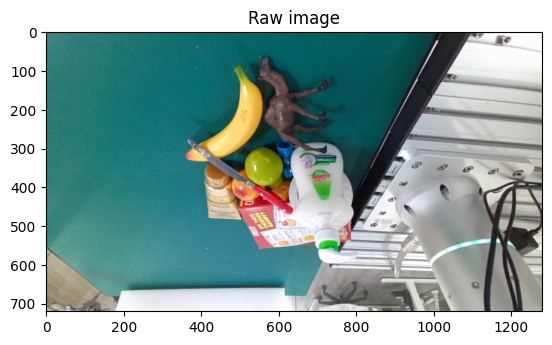

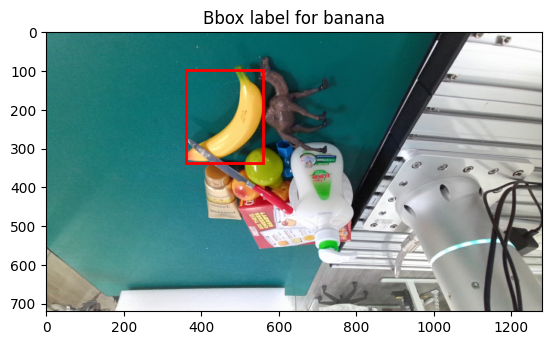

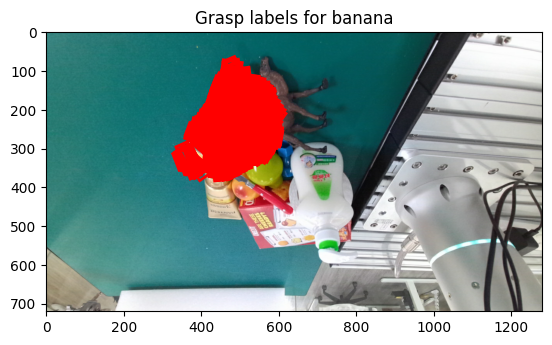

In [107]:
index = 'test_6'
(filename, object , bbox) , grasps = val_prompts_df.loc[index,:] , gt_grasps[index]

print(f'Testing {filename} for {object}')
print(f'GT bbox is {bbox}')
print(f'{len(grasps)} possible grasps exist.')


#draw the raw image
visualise_image(filename, caption = 'Raw image')

#draw the bbox on the image. It must be converted from current 
# format [xmin, ymin, xmax, ymax] into a list with all 4 corner coordinates.
polygon_bbox = [[bbox[0], bbox[1]], [bbox[2], bbox[1]], [bbox[2], bbox[3]], [bbox[0], bbox[3]]]
visualise_image(filename, [polygon_bbox], caption = f'Bbox label for {object}')

#draw the grasps on the image
visualise_image(filename, grasps, caption = f'Grasp labels for {object}')

- **`get_rotated_rectangle_corners`**: This converts the grasp parameters `(center_x, center_y, width, angle_rad)` into the four corner points of a rectangle that represents the grasp area. It helps visualize how the gripper would grasp the object.

In [109]:
def get_rotated_rectangle_corners(center_x, center_y, width, angle_rad):

    # Given a grasp prediction in the format required by the assignment, this function will convert it into 
    # 4 rotated rectangle corners that can be drawn onto an image and visualised. Or compared with a GT grasp
    # for performance evaluation.
    
    #height is fixed based on the gripper 
    height = 30
    
    # Extract center coordinates
    cx, cy = center_x, center_y

    # Calculate half dimensions
    half_width = width / 2
    half_height = height / 2
    
    # Calculate the original corner positions relative to the center
    corners = [
        (-half_width, -half_height),  # Bottom-left
        (half_width, -half_height),   # Bottom-right
        (half_width, half_height),    # Top-right
        (-half_width, half_height)    # Top-left
    ]
    
    # Apply rotation and translation to each corner
    rotated_corners = []
    for x, y in corners:
        # Calculate rotated positions
        rotated_x = cx + (x * math.cos(angle_rad)) - (y * math.sin(angle_rad))
        rotated_y = cy + (x * math.sin(angle_rad)) + (y * math.cos(angle_rad))
        rotated_corners.append((rotated_x, rotated_y))
    
    return rotated_corners


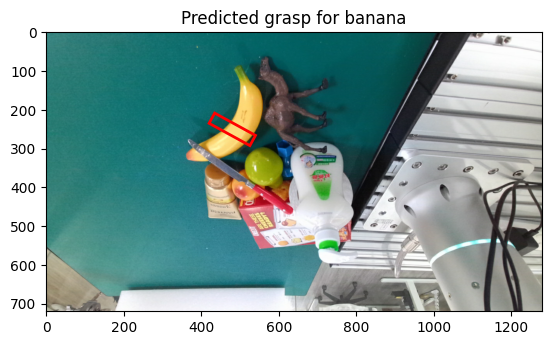

In [116]:
u = 480
v = 250
width = 120
angle = 0.5

predicted_grasp_rect = get_rotated_rectangle_corners(u, v, width, angle)
visualise_image(filename, [predicted_grasp_rect], caption = f'Predicted grasp for {object}')

- **`rotated_rectangle_to_grasp`**: This function reverses the previous one, converting the four corner points of the grasp rectangle into `(center_x, center_y, width, angle_rad)`. This new format makes the grasp parameters easier to handle and analyze.

In [111]:
def rotated_rectangle_to_grasp(corners):
    """
    Convert a set of 4 corners from a rotated rectangle to (center_x, center_y, width, angle_rad).
    
    Args:
        corners (list): List of 4 corners, each corner is a tuple (x, y).
                        The corners should be ordered as [bottom-left, bottom-right, top-right, top-left].
    
    Returns:
        tuple: (center_x, center_y, width, angle_rad) representing the grasp.
    """
    
    # Unpack the corners
    bottom_left, bottom_right, top_right, top_left = corners
    
    # Calculate the center (average of the four corners)
    center_x = (bottom_left[0] + bottom_right[0] + top_right[0] + top_left[0]) / 4
    center_y = (bottom_left[1] + bottom_right[1] + top_right[1] + top_left[1]) / 4
    
    # Calculate the width (distance between bottom-left and bottom-right)
    width = math.sqrt((bottom_right[0] - bottom_left[0])**2 + (bottom_right[1] - bottom_left[1])**2)
    
    # Calculate the angle (using atan2 to get the angle between bottom-left and bottom-right)
    delta_x = bottom_right[0] - bottom_left[0]
    delta_y = bottom_right[1] - bottom_left[1]
    angle_rad = math.atan2(delta_y, delta_x)
    
    return center_x, center_y, width, angle_rad


Center: (431.0626525878906, 157.33883666992188), Width: 68.41932408130832, Angle (radians): -0.35044224897418913


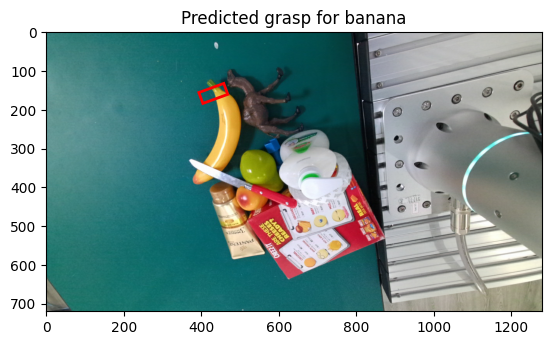

In [124]:
index = 'test_1'
(filename, object , bbox) , grasps = val_prompts_df.loc[index,:] , gt_grasps[index]
corners = grasps[0]

# Get the grasp representation
u, v, width, angle_rad = rotated_rectangle_to_grasp(corners)
print(f"Center: ({u}, {v}), Width: {width}, Angle (radians): {angle_rad}")


predicted_grasp_rect = get_rotated_rectangle_corners(u, v, width, angle_rad)
visualise_image(filename, [predicted_grasp_rect], caption = f'Predicted grasp for {object}')

- **Converting grasps**: We converted all possible grasp points from their rectangular corner format into the simplified format of `(center_x, center_y, width, angle_rad)`. This makes the grasp points easier to use in the next phase of training the grasp detection model.

In [132]:
# Dictionary to store the converted grasp attributes for all scenes
converted_grasps = {}

# Iterate through all the scenes in gt_grasps
for index, grasps in gt_grasps.items():
    converted_grasps[index] = []  # Initialize an empty list to store the converted grasps for each scene
    
    # Convert each set of corners to (center_x, center_y, width, angle_rad)
    for corners in grasps:
        u, v, width, angle_rad = rotated_rectangle_to_grasp(corners)
        converted_grasps[index].append((u, v, width, angle_rad))


In [135]:
len(converted_grasps)

500

Converted grasps for test_1: (431.0626525878906, 157.33883666992188, 68.41932408130832, -0.35044224897418913)


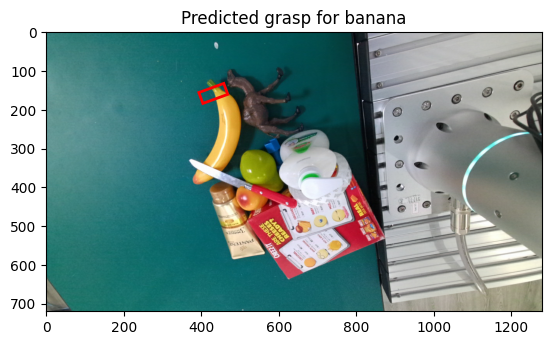

In [136]:
index = 'test_1'
object = val_prompts_df.loc[index,'object']
print(f"Converted grasps for {index}: {converted_grasps[index][0]}")
u, v, width, angle_rad = converted_grasps[index][0]
predicted_grasp_rect = get_rotated_rectangle_corners(u, v, width, angle_rad)
visualise_image(filename, [predicted_grasp_rect], caption = f'Predicted grasp for {object}')

- **Why Grasp Points Were Converted:**

    - Grasp points were converted to a format that is more suitable for training the model. The simplified format `(center_x, center_y, width, angle_rad)` directly represents how a robotic gripper would approach and grasp the object.

    - This new format is essential for model training because it simplifies the problem from predicting complex corner points to predicting intuitive gripper properties like position, size, and angle.

---
## 2. Object Detection

Having completed the dataset preparation and preprocessing phase, we now move on to object detection. In this next phase, we will use a pre-trained object detection model, such as Mask R-CNN, to detect objects in the scene and provide their bounding boxes. These bounding boxes will be used in conjunction with the grasp detection model to identify where the robot can successfully grasp each object.

In [ ]:
# Import required libraries
import torch
import torchvision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights, MaskRCNN_ResNet50_FPN_V2_Weights
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar
from torchvision.transforms import functional as F

# Function to display detected objects
def visualize_detections(image, detections, threshold=0.5, model_name="Model"):
    """
    Visualize object detection bounding boxes with scores greater than threshold.
    Args:
        image (PIL.Image): The input RGB image.
        detections (dict): The detection output from the model.
        threshold (float): Score threshold for displaying bounding boxes.
        model_name (str): Model name to display on the image title.
    """
    image_np = np.array(image)  # Convert PIL image to numpy array
    plt.imshow(image_np)
    
    # Loop through all detections
    for i, box in enumerate(detections['boxes']):
        score = detections['scores'][i].item()
        if score > threshold:
            x_min, y_min, x_max, y_max = box.int()
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='red', linewidth=2, fill=False)
            plt.gca().add_patch(rect)
    
    plt.title(f"{model_name} Detections (Threshold: {threshold})")
    plt.axis('off')
    plt.show()

# Load pre-trained models with respective weights
weights_mrcnn = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
weights_frcnn = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT

model_mrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights_mrcnn)
model_frcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=weights_frcnn)

# Set models to evaluation mode
model_mrcnn.eval()
model_frcnn.eval()

# Preprocessing transformation from the weights
preprocess_mrcnn = weights_mrcnn.transforms()
preprocess_frcnn = weights_frcnn.transforms()

# Load an example image from the validation dataset (modify file path as necessary)
filename = val_prompts_df.iloc[0]['filename']
image = Image.open(filename).convert("RGB")

# Preprocess the image
image_mrcnn = preprocess_mrcnn(image)
image_frcnn = preprocess_frcnn(image)

# Move images to batches and move them to the device (CPU or GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_mrcnn.to(device)
model_frcnn.to(device)

image_mrcnn = image_mrcnn.unsqueeze(0).to(device)
image_frcnn = image_frcnn.unsqueeze(0).to(device)

# Run detection for both models
with torch.no_grad():
    detections_mrcnn = model_mrcnn(image_mrcnn)[0]
    detections_frcnn = model_frcnn(image_frcnn)[0]

# Visualize detections
visualize_detections(image, detections_mrcnn, threshold=0.5, model_name="Mask R-CNN")
visualize_detections(image, detections_frcnn, threshold=0.5, model_name="Faster R-CNN")

# Function to calculate IoU
def calculate_iou(box1, box2):
    """
    Calculate Intersection-over-Union (IoU) between two bounding boxes.
    Args:
        box1 (list): Bounding box [xmin, ymin, xmax, ymax].
        box2 (list): Bounding box [xmin, ymin, xmax, ymax].
    Returns:
        float: IoU score.
    """
    x1, y1, x2, y2 = max(box1[0], box2[0]), max(box1[1], box2[1]), min(box1[2], box2[2]), min(box1[3], box2[3])
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = area_box1 + area_box2 - intersection
    return intersection / union

# Evaluating the models on the validation set
def evaluate_model_on_validation(model, preprocess, val_prompts_df, gt_objects, threshold=0.5, iou_threshold=0.5):
    """
    Evaluate the object detection model on the validation dataset.
    Args:
        model (torch.nn.Module): The object detection model.
        preprocess (callable): Preprocessing function for the model.
        val_prompts_df (DataFrame): DataFrame with validation prompts.
        gt_objects (dict): Ground truth bounding boxes for the validation set.
        threshold (float): Score threshold for valid detections.
        iou_threshold (float): IoU threshold for counting a detection as correct.
    """
    model.eval()
    correct_detections = 0
    total_objects = len(val_prompts_df)
    
    for idx, row in tqdm(val_prompts_df.iterrows(), total=len(val_prompts_df)):
        filename = row['filename']
        target_label = row['label']
        gt_bbox = row['box']
        
        # Load and preprocess image
        image = Image.open(filename).convert("RGB")
        image_tensor = preprocess(image).unsqueeze(0).to(device)
        
        # Run model inference
        with torch.no_grad():
            detections = model(image_tensor)[0]
        
        # Find the best detection for the target object
        for i, label_id in enumerate(detections['labels']):
            score = detections['scores'][i].item()
            if score > threshold:
                pred_bbox = detections['boxes'][i].cpu().numpy()
                iou = calculate_iou(pred_bbox, gt_bbox)
                if iou > iou_threshold:
                    correct_detections += 1
                    break
    
    accuracy = correct_detections / total_objects
    print(f"Model accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Evaluate both models
print("Evaluating Mask R-CNN:")
mrcnn_accuracy = evaluate_model_on_validation(model_mrcnn, preprocess_mrcnn, val_prompts_df, gt_objects)
print("Evaluating Faster R-CNN:")
frcnn_accuracy = evaluate_model_on_validation(model_frcnn, preprocess_frcnn, val_prompts_df, gt_objects)

# Display the results of both models
print(f"Mask R-CNN Accuracy: {mrcnn_accuracy:.2f}")
print(f"Faster R-CNN Accuracy: {frcnn_accuracy:.2f}")


In [152]:
# Function to calculate IoU
def calculate_iou(box1, box2):
    """
    Calculate Intersection-over-Union (IoU) between two bounding boxes.
    """
    x1, y1, x2, y2 = max(box1[0], box2[0]), max(box1[1], box2[1]), min(box1[2], box2[2]), min(box1[3], box2[3])
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    area_box1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area_box2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union = area_box1 + area_box2 - intersection
    return intersection / union

# Evaluating Mask R-CNN model on the validation set
def evaluate_model_on_validation(model, preprocess, val_prompts_df, threshold=0.5, iou_threshold=0.5):
    """
    Evaluate the Mask R-CNN object detection model on the validation dataset.
    """
    model.eval()
    correct_detections = 0
    total_objects = len(val_prompts_df)
    
    for idx, row in tqdm(val_prompts_df.iterrows(), total=len(val_prompts_df)):
        filename = row['filename']
        target_label = row['object']
        gt_bbox = row['bbox']
        
        # Load and preprocess image
        image = Image.open(filename).convert("RGB")
        image_tensor = preprocess(image).unsqueeze(0)
        
        # Run model inference
        with torch.no_grad():
            detections = model(image_tensor)[0]
        
        # Find the best detection for the target object
        for i, label_id in enumerate(detections['labels']):
            score = detections['scores'][i].item()
            if score > threshold:
                pred_bbox = detections['boxes'][i].cpu().numpy()
                iou = calculate_iou(pred_bbox, gt_bbox)
                if iou > iou_threshold:
                    correct_detections += 1
                    break
    
    accuracy = correct_detections / total_objects
    print(f"Model accuracy: {accuracy * 100:.2f}%")
    return accuracy



In [153]:
# Import the required libraries
import torch
import torchvision
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar
import numpy as np
import cv2

# Load the pre-trained Mask R-CNN model with weights
weights_mrcnn = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model_mrcnn = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights_mrcnn)

# Set the model to evaluation mode
model_mrcnn.eval()

# Preprocessing transformation from the weights
preprocess_mrcnn = weights_mrcnn.transforms()



# Evaluate the Mask R-CNN model on validation set
print("Evaluating Mask R-CNN on Validation Set:")
mrcnn_accuracy = evaluate_model_on_validation(model_mrcnn, preprocess_mrcnn, val_prompts_df)
print(f"Mask R-CNN Accuracy: {mrcnn_accuracy:.2f}")

Evaluating Mask R-CNN on Validation Set:


100%|██████████| 500/500 [47:58<00:00,  5.76s/it]

Model accuracy: 63.20%
Mask R-CNN Accuracy: 0.63


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import box_iou

def calculate_iou(pred_boxes, gt_boxes):
    """
    Calculate IoU (Intersection over Union) between predicted boxes and ground-truth boxes.

    Args:
        pred_boxes (Tensor): Predicted bounding boxes (N, 4) in the format [x_min, y_min, x_max, y_max].
        gt_boxes (Tensor): Ground-truth bounding boxes (M, 4) in the format [x_min, y_min, x_max, y_max].

    Returns:
        iou (Tensor): IoU scores for each pair of predicted and ground-truth boxes.
    """
    return box_iou(pred_boxes, gt_boxes)


def precision_recall_curve(pred_boxes, gt_boxes, iou_threshold=0.5):
    """
    Calculate precision and recall at a given IoU threshold.

    Args:
        pred_boxes (Tensor): Predicted bounding boxes (N, 4).
        gt_boxes (Tensor): Ground-truth bounding boxes (M, 4).
        iou_threshold (float): Threshold to consider a detection as True Positive.

    Returns:
        precision (float): Precision score.
        recall (float): Recall score.
    """
    iou_matrix = calculate_iou(pred_boxes, gt_boxes)
    true_positives = (iou_matrix > iou_threshold).sum().item()
    
    precision = true_positives / max(len(pred_boxes), 1)  # To avoid division by zero
    recall = true_positives / max(len(gt_boxes), 1)       # To avoid division by zero

    return precision, recall


def plot_precision_recall_curve(pred_boxes, gt_boxes, thresholds=np.linspace(0.1, 0.9, 9)):
    """
    Plot Precision-Recall curve for multiple IoU thresholds.

    Args:
        pred_boxes (Tensor): Predicted bounding boxes (N, 4).
        gt_boxes (Tensor): Ground-truth bounding boxes (M, 4).
        thresholds (array): List of IoU thresholds to plot the curve.
    """
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        precision, recall = precision_recall_curve(pred_boxes, gt_boxes, iou_threshold=threshold)
        precisions.append(precision)
        recalls.append(recall)
    
    plt.plot(recalls, precisions, marker='o')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid()
    plt.show()


def calculate_mean_average_precision(pred_boxes, gt_boxes, iou_thresholds=np.arange(0.5, 1.0, 0.05)):
    """
    Calculate mean Average Precision (mAP) across multiple IoU thresholds.

    Args:
        pred_boxes (Tensor): Predicted bounding boxes (N, 4).
        gt_boxes (Tensor): Ground-truth bounding boxes (M, 4).
        iou_thresholds (array): IoU thresholds to calculate AP for each class.

    Returns:
        mAP (float): The mean Average Precision score across IoU thresholds.
    """
    ap_values = []
    
    for iou_threshold in iou_thresholds:
        precision, recall = precision_recall_curve(pred_boxes, gt_boxes, iou_threshold=iou_threshold)
        ap = (precision * recall) / max(recall, 1)  # Area under precision-recall curve approximation
        ap_values.append(ap)
    
    mean_ap = np.mean(ap_values)
    return mean_ap


def f1_score(precision, recall):
    """
    Calculate F1 Score, the harmonic mean of precision and recall.

    Args:
        precision (float): Precision score.
        recall (float): Recall score.

    Returns:
        f1 (float): F1 score.
    """
    if precision + recall == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


def evaluate_object_detection_model(model, dataloader, iou_threshold=0.5, score_threshold=0.5):
    """
    Evaluate an object detection model on a dataset using precision, recall, IoU, and F1 score.

    Args:
        model (torch.nn.Module): Pretrained object detection model.
        dataloader (torch.utils.data.DataLoader): Dataloader containing the test/validation dataset.
        iou_threshold (float): IoU threshold to consider a detection as true positive.
        score_threshold (float): Confidence score threshold for filtering detections.

    Returns:
        dict: Dictionary containing evaluation metrics: precision, recall, F1 score, mAP.
    """
    all_precisions = []
    all_recalls = []
    all_f1_scores = []
    all_aps = []

    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():
        for images, targets in dataloader:
            # Make predictions
            predictions = model(images)
            
            for i, prediction in enumerate(predictions):
                pred_boxes = prediction['boxes'][prediction['scores'] > score_threshold]
                gt_boxes = targets[i]['boxes']

                # Calculate precision, recall, IoU
                precision, recall = precision_recall_curve(pred_boxes, gt_boxes, iou_threshold=iou_threshold)
                f1 = f1_score(precision, recall)
                ap = calculate_mean_average_precision(pred_boxes, gt_boxes)

                all_precisions.append(precision)
                all_recalls.append(recall)
                all_f1_scores.append(f1)
                all_aps.append(ap)

    metrics = {
        "Precision": np.mean(all_precisions),
        "Recall": np.mean(all_recalls),
        "F1 Score": np.mean(all_f1_scores),
        "mAP": np.mean(all_aps)
    }
    
    return metrics


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Softmax function to convert logits into probabilities
softmax_fn = torch.nn.Softmax(dim=1)

def compute_confidence_calibration(model, dataloader, device, num_classes):
    """
    Compute the confidence calibration data for a given model using a test dataloader.
    
    Args:
        model: The object detection or classification model.
        dataloader: The dataloader containing test/validation data.
        device: The device (CPU/GPU) where the model is loaded.
        num_classes: Number of output classes for the model.

    Returns:
        all_gt (list): List of all ground truth labels.
        all_pred (list): List of all predicted labels.
        all_confidences (list): List of all confidence scores (softmax probabilities).
    """
    all_gt = []
    all_pred = []
    all_confidences = []

    # Set model to evaluation mode
    model.eval()

    # Loop through the dataloader
    with torch.no_grad():
        for data in tqdm(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)

            # Forward pass through the model
            outputs = model(inputs)

            # Apply softmax to get class probabilities
            scores = softmax_fn(outputs)

            # Get the predicted class and its corresponding confidence score
            _, predicted = torch.max(scores, 1)
            confidences = torch.max(scores, 1)[0]

            # Append results
            all_gt.extend(labels.cpu().numpy())
            all_pred.extend(predicted.cpu().numpy())
            all_confidences.extend(confidences.cpu().numpy())

    return all_gt, all_pred, all_confidences


def plot_confidence_calibration(all_gt, all_pred, all_confidences):
    """
    Plot the confidence calibration curve and the distribution of confidence levels.
    
    Args:
        all_gt: List of ground truth labels.
        all_pred: List of predicted labels.
        all_confidences: List of confidence scores (probabilities).
    """
    # Confidence intervals for the bins
    conf_ranges = [[0, 10], [10, 20], [20, 30], [30, 40], [40, 50],
                   [50, 60], [60, 70], [70, 80], [80, 90], [90, 100]]

    # Convert lists to numpy arrays for easy manipulation
    all_pred_conf = np.array(all_confidences)
    all_pred_class = np.array(all_pred)
    all_gt_class = np.array(all_gt)

    actual_accuracy = []
    conf_level = []
    conf_counts = []

    for conf_int in conf_ranges:
        lower = conf_int[0] / 100  # Convert to [0-1] range
        upper = conf_int[1] / 100  # Convert to [0-1] range

        # Create a mask to filter predictions within the current confidence range
        mask = (all_pred_conf >= lower) & (all_pred_conf < upper)

        # Get predictions and ground-truths within the mask
        preds = all_pred_class[mask]
        gt = all_gt_class[mask]

        # Calculate accuracy in the confidence interval
        correct = np.sum(preds == gt)
        total = len(preds)
        accuracy = correct / total if total > 0 else 0
        actual_accuracy.append(accuracy)

        # Average confidence level for the interval
        conf_level.append((upper + lower) / 2)

        # Count the number of predictions in the bin
        conf_counts.append(len(preds))

    # Create a figure with two subplots (for calibration curve and confidence distribution)
    fig, ax = plt.subplots(2, 1, figsize=(5, 7))

    # Plot the calibration curve
    ax[0].bar(conf_level, actual_accuracy, width=0.09, color='b', alpha=0.6)
    ax[0].plot([0, 1], [0, 1], 'r--')  # Plot the ideal calibration line
    ax[0].set_xlabel('Confidence')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Confidence Calibration Curve')

    # Plot the confidence level distribution
    ax[1].bar(conf_level, conf_counts, width=0.09, color='g', alpha=0.6)
    ax[1].set_xlabel('Confidence')
    ax[1].set_ylabel('Count')
    ax[1].set_title('Confidence Distribution')

    # Show the plot
    plt.tight_layout()
    plt.savefig('Confidence_curve.png')
    plt.show()


# Example Usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Assuming model and dataloader are predefined
all_gt, all_pred, all_confidences = compute_confidence_calibration(model, dataloader, device, num_classes)

# Plot the confidence calibration curves
plot_confidence_calibration(all_gt, all_pred, all_confidences)


---
## 3. Grasp Pose Detection

---
## 4. Evaluation and Visualization

---
## 5. Conclusion and Future Work